In [1]:
#!pip install gym
import gym
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import deque

#!pip install keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Flatten
from keras.layers.convolutional import Conv2D
from keras import backend as K

Using TensorFlow backend.
C:\Users\auste\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\auste\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\auste\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\auste\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

(210, 160, 3)


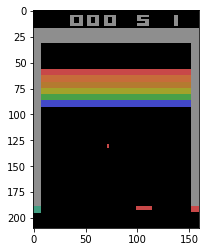

In [2]:
env = gym.make('BreakoutDeterministic-v4')
observation = env.reset()

for i in range(3):
    # The ball is released after 2 frames
    if i > 1:
        print(observation.shape)
        plt.imshow(observation)
        plt.show()
        
    # Get the next observation
    observation, _, _, _ = env.step(1)

In [3]:
def preprocess_frame(frame):
    frame = frame[30:200, 10:150]
    
    # grayscale frame and downsize by factor 2
    frame = frame[::2, ::2, 0]
    
    # set background to 0
    frame[frame == 144] = 0
    frame[frame == 109] = 0
    
    # set ball and paddles to 1
    frame[frame != 0] = 1
    
    return frame

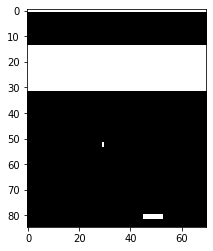

In [4]:
obs_preprocessed = preprocess_frame(observation)
plt.imshow(obs_preprocessed, cmap='gray')
plt.show()

In [7]:
class DQLAgent:
    def __init__(self, cols, rows, n_actions, batch_size=32, booleanPrint = True):
        self.state_size = (cols, rows, 4)
        self.n_actions = n_actions
        self.epsilon = 1.
        self.epsilon_start, self.epsilon_end = 1.0, 0.1
        self.exploration_steps = 1000000.
        self.epsilon_decay_step = (self.epsilon_start - self.epsilon_end) / self.exploration_steps
        self.batch_size = batch_size
        self.discount_factor = 0.99
        self.memory = deque(maxlen=400000)
        self.model = self.build_model(booleanPrint)
        self.target_model = self.build_model(booleanPrint)
        self.optimizer = self.optimizer()
        self.avg_q_max, self.avg_loss = 0, 0

    def optimizer(self):
        a = K.placeholder(shape=(None,), dtype='int32')
        y = K.placeholder(shape=(None,), dtype='float32')

        py_x = self.model.output

        a_one_hot = K.one_hot(a, self.n_actions)
        q_value = K.sum(py_x * a_one_hot, axis=1)
        error = K.abs(y - q_value)

        quadratic_part = K.clip(error, 0.0, 1.0)
        linear_part = error - quadratic_part
        loss = K.mean(0.5 * K.square(quadratic_part) + linear_part)

        opt = Adam(lr=0.00025, epsilon=0.01)
        updates = opt.get_updates(self.model.trainable_weights, [], loss)
        train = K.function([self.model.input, a, y], [loss], updates=updates)

        return train

    def build_model(self, booleanPrint):
        model = Sequential()
        model.add(Conv2D(32, (8, 8), strides=(4, 4), activation='relu', input_shape=self.state_size))
        model.add(Conv2D(64, (4, 4), strides=(2, 2), activation='relu'))
        model.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu'))
        model.add(Flatten())
        model.add(Dense(512, activation='relu'))
        model.add(Dense(self.n_actions))
        if booleanPrint:
            model.summary()
        return model

    def update_model(self):
        self.target_model.set_weights(self.model.get_weights())

    def action(self, history):
        history = np.float32(history / 255.0)
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.n_actions)
        else:
            q_value = self.model.predict(history)
            return np.argmax(q_value[0])

    def replay(self, history, action, reward, next_history, dead):
        self.memory.append((history, action, reward, next_history, dead))

    def train(self):
        if len(self.memory) < self.batch_size:
            return
        if self.epsilon > self.epsilon_end:
            self.epsilon -= self.epsilon_decay_step

        mini_batch = random.sample(self.memory, self.batch_size)
        history = np.zeros((self.batch_size, self.state_size[0], self.state_size[1], self.state_size[2]))
        next_history = np.zeros((self.batch_size, self.state_size[0], self.state_size[1], self.state_size[2]))
        target = np.zeros((self.batch_size,))
        action, reward, dead = [], [], []

        for i in range(self.batch_size):
            history[i] = np.float32(mini_batch[i][0] / 255.)
            next_history[i] = np.float32(mini_batch[i][3] / 255.)
            action.append(mini_batch[i][1])
            reward.append(mini_batch[i][2])
            dead.append(mini_batch[i][4])

        target_value = self.target_model.predict(next_history)

        for i in range(self.batch_size):
            if dead[i]:
                target[i] = reward[i]
            else:
                target[i] = reward[i] + self.discount_factor * \
                                        np.amax(target_value[i])

        loss = self.optimizer([history, action, target])
        self.avg_loss += loss[0]

In [8]:
env = gym.make('BreakoutDeterministic-v4')

# General settings
update_model_rate = 10000
cols, rows = 85, 70
n_states = 4

# Hyperparameters
batch_size = 32

# Initialization
agent = DQLAgent(cols, rows, n_actions=3)
scores, episodes = [], []
n_steps = 0

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 16, 32)        8224      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 9, 7, 64)          32832     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 5, 64)          36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 2240)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1147392   
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 1539      
Total params: 1,226,915
Trainable params: 1,226,915
Non-trainable params: 0
____________________________________________

In [12]:
iteration = 0 
while True:
    done = False
    dead = False
    step, score, start_life = 0, 0, 5
    observation = env.reset()


    state = preprocess_frame(observation)
    history = np.stack((state, state, state, state), axis=2)
    history = np.reshape([history], (1, cols, rows, n_states))

    while not done:
#       env.render()
        n_steps += 1
        step += 1
        
        # Get action
        action = agent.action(history)
        observation, reward, done, info = env.step(action+1)
        
        # Extract next state
        state_next = preprocess_frame(observation)
        state_next = np.reshape([state_next], (1, cols, rows, 1))
        history_next = np.append(state_next, history[:, :, :, :3], axis=3)

        agent.avg_q_max += np.amax(agent.model.predict(history)[0])
        reward = np.clip(reward, -1., 1.)

        agent.replay(history, action, reward, history_next, dead)
        agent.train()
        if n_steps % update_model_rate == 0:
            agent.update_model()
        score += reward

        if dead:
            dead = False
        else:
            history = history_next

        if done:
            print('episode {:2d}; score: {:2.0f}; q {:2f}; loss {:2f}; steps {}'
                  .format(n_steps, score, agent.avg_q_max / float(step), agent.avg_loss / float(step), step))

            agent.avg_q_max, agent.avg_loss = 0, 0
    
    # Save weights of model
    if iteration == 200: #train 200 times
        agent.model.save_weights("breakout_dql.h5")
        break
    if iteration % 50 == 0:
        print(f'Iteration {iteration}')
    iteration += 1

episode 1582; score:  3; q 1.902821; loss 0.464804; steps 225
Iteration 0
episode 1858; score:  3; q 1.208713; loss 0.371558; steps 276
episode 2116; score:  3; q 1.241204; loss 0.347233; steps 258
episode 2294; score:  1; q 1.219222; loss 0.348310; steps 178
episode 2443; score:  0; q 1.399869; loss 0.350523; steps 149
episode 2662; score:  2; q 1.091328; loss 0.364403; steps 219
episode 2833; score:  1; q 0.969700; loss 0.355108; steps 171
episode 3095; score:  3; q 0.995472; loss 0.368979; steps 262
episode 3260; score:  1; q 0.959200; loss 0.333000; steps 165
episode 3547; score:  3; q 1.130420; loss 0.332685; steps 287
episode 3676; score:  0; q 1.268659; loss 0.346417; steps 129
episode 3811; score:  0; q 1.128877; loss 0.358631; steps 135
episode 4066; score:  3; q 1.126571; loss 0.324202; steps 255
episode 4381; score:  4; q 1.147389; loss 0.344157; steps 315
episode 4606; score:  3; q 0.986312; loss 0.329597; steps 225
episode 4742; score:  0; q 0.808460; loss 0.362753; steps 

episode 26002; score:  3; q 0.876879; loss 0.346821; steps 274
episode 26251; score:  3; q 0.816635; loss 0.354114; steps 249
episode 26420; score:  1; q 0.889423; loss 0.342664; steps 169
episode 26551; score:  0; q 0.790869; loss 0.340333; steps 131
episode 26723; score:  1; q 0.790705; loss 0.363580; steps 172
episode 26947; score:  2; q 0.877435; loss 0.323445; steps 224
episode 27117; score:  1; q 0.853827; loss 0.331229; steps 170
episode 27292; score:  1; q 0.921011; loss 0.339368; steps 175
episode 27428; score:  0; q 0.940601; loss 0.341341; steps 136
episode 27611; score:  1; q 0.913975; loss 0.329512; steps 183
episode 27789; score:  1; q 0.917739; loss 0.343918; steps 178
episode 27972; score:  1; q 0.863972; loss 0.355837; steps 183
episode 28126; score:  1; q 0.894794; loss 0.295610; steps 154
episode 28304; score:  1; q 0.841191; loss 0.332218; steps 178
episode 28538; score:  3; q 0.841378; loss 0.347337; steps 234
episode 28738; score:  2; q 0.818583; loss 0.326469; st

In [14]:
env = gym.make('BreakoutDeterministic-v4')
agent = DQLAgent(cols, rows, n_actions=3, booleanPrint = False)

for i in range(5):
    observation = env.reset()

    state = preprocess_frame(observation)
    history = np.stack((state, state, state, state), axis=2)
    history = np.reshape([history], (1, cols, rows, n_states))
    done = False
    while not done:
        env.render()
        action = agent.action(history)
        observe, reward, done, info = env.step(action+1)
env.close()